In [79]:
# access to different databases
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from tqdm import tqdm
import time
from scipy.optimize import minimize

# statistics and regression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
import quantstats as qs
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.axis import Axis
import matplotlib.dates as mdates 
%matplotlib inline

from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from pandas.tseries.offsets import BDay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, power_transform
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

#import linearmodels as lm
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
from scipy.stats import yeojohnson, boxcox

# warning
import warnings
warnings.filterwarnings("ignore")

# unzipping zip-files
from zipfile import ZipFile

In [80]:
path =  Path(r'C:\Users\choux\OneDrive\quantative_trading')

In [81]:
Path_stocks = Path(path/'permno_selection.csv')
df_input_stocks = pd.read_csv(Path_stocks)
Path_linker = Path(path/'daily_permno_secid_cusip_link.csv.zip')
zip_file = ZipFile(Path_linker)
df_link_permno_secid = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))
Path1 = Path(path/'assignment1_final.h5')
glb = path / 'glb_daily.csv'
mfis = path / 'mfis.csv'

In [82]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            order by date, permno
            """
    # TODO: Add ORDER BY above.
    
    # define the parameters, i.e. only those companies (permno), which were part of the S&P 500
    # in the timeframe 2000/01 until 2020/12
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    print(df_stock_data.shape)
    
    # dropna
    df_stock_data.dropna(inplace=True)
    print(df_stock_data.shape)
    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date') \
                        .sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True)
    
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

In [83]:
def download_ffm(date_start, date_end):
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

In [84]:
def calc_excess_return(df, minuend, subtrahend):
    # calculate excess return
    df['excess_return'] = df[minuend]-df[subtrahend]
    return df

In [85]:
def data_prep(df_input, date_start, date_end, df_link, wrds_username, minuend, subtrahend):

    ## retrieve data
    df_stock_data = retrieve_stock_data(df_input=df_input_stocks, 
                                        date_start=date_start, 
                                        date_end=date_end, 
                                        wrds_username=wrds_username)
    
    # change type of entries in the columns date
    df_link['date']  = pd.to_datetime(df_link['date'])
    
    ## merge with cusip
    df_stock_data = pd.merge(df_stock_data, df_link.loc[:,['permno', 'date', 'secid']], how = "left", on = ['permno','date'])
    
    
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    
    ## merge stock data with ffm
    # merge with ff-4-factors
    df_stocks_ffm = pd.merge(df_stock_data, df_ffm, how='inner', on=['date'])
    
    # calculate excess return
    df_stocks_ffm = calc_excess_return(df=df_stocks_ffm, minuend=minuend, subtrahend=subtrahend)
    
    return df_stocks_ffm

In [86]:
df_prepared = data_prep(df_input=df_input_stocks,
                        date_start='1999-01-01',
                        date_end='2020-12-31',
                        df_link=df_link_permno_secid,
                        wrds_username='chouxy141319',
                        minuend='ret',
                        subtrahend='rf')

Loading library list...
Done
(276800, 8)
(276747, 8)


In [87]:
df_prepared

,date,permno,cusip,ret,prc,weightage_pct,secid,mktrf,smb,hml,mom,rf,excess_return
0,1999-01-05,10874.0,11704310,0.018519,24.062500,0.001989,102386.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.018329
1,1999-01-05,47466.0,65011110,0.030965,35.375000,0.005459,108117.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.030775
2,1999-01-05,47626.0,12611710,0.000000,40.375000,0.006508,102548.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,-0.000190
3,1999-01-05,48486.0,51280710,0.328947,25.250000,0.000640,106808.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.328757
4,1999-01-05,51369.0,88077010,0.083086,45.625000,0.003107,110952.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.082896
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276742,2020-12-31,24205.0,65339F10,0.016335,77.150002,0.046879,104560.0,0.0039,-0.0087,0.0043,-0.0059,0.00000,0.016335
276743,2020-12-31,25320.0,13442910,0.006872,48.349998,0.004576,102660.0,0.0039,-0.0087,0.0043,-0.0059,0.00000,0.006872
276744,2020-12-31,26825.0,48783610,0.011377,62.230000,0.006667,106638.0,0.0039,-0.0087,0.0043,-0.0059,0.00000,0.011377
276745,2020-12-31,18729.0,19416210,0.009206,85.510002,0.022894,103157.0,0.0039,-0.0087,0.0043,-0.0059,0.00000,0.009206


In [88]:
df_prepared.groupby('date')['weightage_pct'].sum()

date
1999-01-05    1.0
1999-01-06    1.0
1999-01-07    1.0
1999-01-08    1.0
1999-01-11    1.0
             ... 
2020-12-24    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Name: weightage_pct, Length: 5535, dtype: float64

In [89]:
def estimate_betas(df, window_size, factors, period='daily'):
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df['permno'] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno['excess_return']
            # independent variable
            X = df_current_permno[factors]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    for col in factors:
        df_params.rename(columns={col: col+str('_beta')}, inplace=True)
    # df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print('Merging the dataframes...')
    df_betas = pd.merge(df, df_params, how='left', left_index=True, right_index=True, suffixes=[None, None])
    print('Merging completed.')
    
    if period == 'daily':
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas
    
    if period == 'monthly':
        # add '_factor' to the entries in list factors
        ls_factors_betas = [factors[i] + str('_beta') for i in list(range(len(factors)))]
        # create a temporary copy of df_betas
        cols2copy=['permno', 'date', 'const']+ls_factors_betas
        df_temp = df_betas[cols2copy].copy()
        #df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month
        # group dataframe and select last row 
        df_temp = df_temp.groupby(['permno','year', 'month']).tail(n=1)
        
        # rename columns to indicate that those are the betas of the end of each month
        for col in cols2copy[2:]:
            df_temp.rename(columns={col: col+str('_eom')}, inplace=True)
        # df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_betas
        df_betas_monthly = pd.merge(df_betas, df_temp, how='left', on=['date', 'permno'])
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby('permno')
        cols_eom = cols2copy[2:]
        cols_eom = [cols_eom[i] + str('_eom') for i in list(range(len(cols_eom)))]
        for var in cols_eom:
            df_betas_monthly[var] = gb[var].ffill()
        
        # drop daily betas
        #df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)
        df_betas_monthly.drop(['const', 'year', 'month'] + ls_factors_betas + factors, axis = 1, inplace=True)
        # drop nas
        print(df_betas_monthly.shape)
        df_betas_monthly.dropna(inplace=True)
        print(df_betas_monthly.shape)
        
        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)
        
        return df_betas_monthly

In [90]:
factors = ['mktrf', 'smb', 'hml', 'mom']

df_betas = estimate_betas(df=df_prepared, window_size=252, factors=factors, period='monthly')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


Merging the dataframes...
Merging completed.
(276747, 14)
(263247, 14)


In [93]:
df_betas.groupby('date')['weightage_pct'].sum()

date
2000-01-31    1.0
2000-02-01    1.0
2000-02-02    1.0
2000-02-03    1.0
2000-02-04    1.0
             ... 
2020-12-24    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Name: weightage_pct, Length: 5265, dtype: float64

In [91]:
# glb
df_glb = pd.read_csv(glb)
## rename column
df_glb = df_glb.rename(columns={"id": "permno"})
## transfrom data type
df_glb['date'] = pd.to_datetime(df_glb['date'])
# mfis
df_mfis = pd.read_csv(mfis)
## rename column
df_mfis = df_mfis.rename(columns={"id": "permno"})
## transfrom data type
df_mfis['date'] = pd.to_datetime(df_glb['date'])

In [92]:
# merge data with glb
df_stocks_betas_options = pd.merge(df_betas, df_glb, how="left", on=['permno', 'date'])
# merge data with mfis
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_mfis, how='left', on=['permno', 'date'])

In [94]:
df_stocks_betas_options.groupby('date')['weightage_pct'].sum()

date
2000-01-31    1.0
2000-02-01    1.0
2000-02-02    1.0
2000-02-03    1.0
2000-02-04    1.0
             ... 
2020-12-24    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Name: weightage_pct, Length: 5265, dtype: float64

In [96]:
df_stocks_betas_options.fillna(method='ffill', inplace=True)

In [98]:
df_stocks_betas_options

,date,permno,cusip,ret,prc,weightage_pct,secid,rf,excess_return,const_eom,...,glb3_D182,glb2_D273,glb3_D273,glb2_D365,glb3_D365,mfis30,mfis91,mfis182,mfis273,mfis365
0,2000-01-31,61241.0,00790310,0.021277,36.000000,0.004653,101121.0,0.00021,0.021067,0.001023,...,0.109763,0.096756,0.096606,0.093748,0.093602,-0.200818,0.034994,0.103173,0.163144,0.188699
1,2000-01-31,56274.0,20588710,0.036254,21.437500,0.009096,103313.0,0.00021,0.036044,-0.000982,...,0.034456,0.096756,0.096606,0.093748,0.093602,0.411800,0.040337,-0.250504,0.163144,0.188699
2,2000-01-31,53613.0,59511210,0.036458,62.187500,0.013615,107544.0,0.00021,0.036248,-0.000732,...,0.065045,0.059534,0.059514,0.059453,0.059433,-0.196034,-0.141617,-0.039893,0.030999,0.095062
3,2000-01-31,53065.0,46069010,-0.021277,46.000000,0.011782,106329.0,0.00021,-0.021487,-0.000090,...,0.065045,0.059534,0.059514,0.059453,0.059433,-0.770791,-0.280034,-0.280038,0.030999,0.095062
4,2000-01-31,47466.0,65011110,-0.013495,45.687500,0.007049,108117.0,0.00021,-0.013705,0.001423,...,0.065045,0.059534,0.059514,0.059453,0.059433,-0.682779,-0.008300,-0.007227,0.030999,0.095062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263292,2020-12-31,24205.0,65339F10,0.016335,77.150002,0.046879,104560.0,0.00000,0.016335,0.001267,...,0.093861,0.104498,0.105987,0.106649,0.108175,-1.315134,-1.266830,-1.193949,-1.092384,-1.035077
263293,2020-12-31,25320.0,13442910,0.006872,48.349998,0.004576,102660.0,0.00000,0.006872,0.000428,...,0.064927,0.061532,0.062255,0.062504,0.063150,-0.658668,-0.647218,-0.669322,-0.626716,-0.731296
263294,2020-12-31,26825.0,48783610,0.011377,62.230000,0.006667,106638.0,0.00000,0.011377,0.000154,...,0.065033,0.063067,0.063999,0.062857,0.063785,-0.898440,-0.870173,-0.854332,-0.809697,-0.710303
263295,2020-12-31,18729.0,19416210,0.009206,85.510002,0.022894,103157.0,0.00000,0.009206,0.000622,...,0.081495,0.079947,0.081076,0.080567,0.081668,-0.864212,-1.308622,-1.148902,-1.092384,-1.035077


In [99]:
df_stocks_betas_options.columns

Index(['date', 'permno', 'cusip', 'ret', 'prc', 'weightage_pct', 'secid', 'rf',
       'excess_return', 'const_eom', 'mktrf_beta_eom', 'smb_beta_eom',
       'hml_beta_eom', 'mom_beta_eom', 'glb2_D30', 'glb3_D30', 'glb2_D91',
       'glb3_D91', 'glb2_D182', 'glb3_D182', 'glb2_D273', 'glb3_D273',
       'glb2_D365', 'glb3_D365', 'mfis30', 'mfis91', 'mfis182', 'mfis273',
       'mfis365'],
      dtype='object')

In [100]:
def train_test_split_sorted(df, date_of_split, dates):   
    
    date_of_split = pd.to_datetime(date_of_split)
    X_train = df[(df["date"] <= date_of_split) & (df['date'] > pd.datetime(1999, 12, 31))]
    X_test = df[(df["date"] > date_of_split) & (df['date'] < pd.datetime(2020, 1, 1))]
    
    X_train = X_train.sort_values(by=['date','permno'])
    X_test = X_test.sort_values(by=['date','permno'])

    return X_train, X_test

In [107]:
df_train, df_test = train_test_split_sorted(df_stocks_betas_options,pd.datetime(2012, 12, 31),df_betas.date)

In [108]:
df_stocks_betas_options.loc[:,'fret1d'] = df_stocks_betas_options.groupby(['permno'])['ret'].shift(-1)
df_stocks_betas_options['constant'] = 1

## TODO: Must split train test first and then do 
1. Normalization
2. Winsorization
3. Scaling

for train, then apply same parameters for test in rolling.

In [109]:
mms = MinMaxScaler()
betas = ['mktrf_beta_eom', 'smb_beta_eom',
       'hml_beta_eom', 'mom_beta_eom', 'glb2_D30', 'glb3_D30', 'glb2_D91',
       'glb3_D91', 'glb2_D182', 'glb3_D182', 'glb2_D273', 'glb3_D273',
       'glb2_D365', 'glb3_D365', 'mfis30', 'mfis91', 'mfis182', 'mfis273',
       'mfis365']

for i in betas:
    df_train[i+'_ws'], lmbda_train = yeojohnson(df_train.loc[:, i])
    df_test[i+'_ws'], lmbda_test = yeojohnson(df_test.loc[:,i])
    df_train[i+'_ws'] = winsorize(df_train[i+'_ws'], limits = 0.001).data
    df_test[i+'_ws'] = winsorize(df_test[i+'_ws'], limits = 0.001).data

X_train = mms.fit_transform(df_train.loc[:, [i+'_ws' for i in betas]])
X_test = mms.transform(df_test.loc[:, [i + '_ws' for i in betas]])
Y_train = df_train['fret1d']
Y_test = df_test['fret1d']

In [110]:
def pred_fit(model, X_train, Y_train, X_test, Y_test, return_pred=False):
    model_name = str(model).split('(')[0]
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(Y_train, y_train_pred)
    r2_test = r2_score(Y_test, y_test_pred)
    mse_train = mean_squared_error(Y_train, y_train_pred)
    mse_test = mean_squared_error(Y_test, y_test_pred)
    mae_train = mean_absolute_error(Y_train, y_train_pred)
    mae_test = mean_absolute_error(Y_test, y_test_pred)
    
    print(f'R2 score - train sample: {r2_train}')
    print(f'R2 score - test sample: {r2_test}')
    print(f'MSE score - train sample: {mse_train}')
    print(f'MSE score - test sample: {mse_test}')
    print(f'MAE score - train sample: {mae_train}')
    print(f'MAE score - test sample: {mae_test}')
    
    if return_pred:
        return y_train_pred, y_test_pred


## Lasso

In [111]:
params = {'alpha': [1e-3, 5*1e-2, 3*1e-2, 1e-2, 1e-1,1e-1, 1, 5, 10, 20]}
lassolr = Lasso(max_iter=1e4)
lassolr_cv = GridSearchCV(lassolr, params, scoring='neg_mean_squared_error', cv=5, verbose=1)
lassolr_cv.fit(X_train, Y_train)

print(f'Max accuracy score is{lassolr_cv.best_score_} and we have {lassolr_cv.best_params_}.')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Max accuracy score is-0.0007280924527007745 and we have {'alpha': 0.001}.


In [112]:
lassolr = Lasso(max_iter=1e4)
lassolr.set_params(**lassolr_cv.best_params_)
lassolr.fit(X_train, Y_train)

Lasso(alpha=0.001, max_iter=10000.0)

In [113]:
pred_fit(lassolr, X_train, Y_train, X_test, Y_test)

R2 score - train sample: 0.0
R2 score - test sample: -0.00011422154829521247
MSE score - train sample: 0.0007280776479159849
MSE score - test sample: 0.0003217202190907089
MAE score - train sample: 0.016555191227224177
MAE score - test sample: 0.011445216040672604


## Ridge

In [59]:
params = {'alpha': [1e-15, 1e-14, 1e-13, 1e-12,1e-11, 1e-10,1e-9, 1, 5, 10, 20]}
ridgelr = Ridge(max_iter=1e4)
ridgelr_cv = GridSearchCV(ridgelr, params, scoring='neg_mean_squared_error', 
                          cv=5, verbose=1)
ridgelr_cv.fit(X_train, Y_train)

print(f'Max accuracy score is {ridgelr_cv.best_score_} and we have {ridgelr_cv.best_params_}.')

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Max accuracy score is -0.0006739175196451369 and we have {'alpha': 20}.


In [60]:
ridgelr = Ridge(max_iter=1e4)
ridgelr.set_params(**ridgelr_cv.best_params_)
ridgelr.fit(X_train, Y_train)

Ridge(alpha=20, max_iter=10000.0)

In [62]:
pred_fit(ridgelr, X_train, Y_train, X_test, Y_test)

R2 score - train sample: 0.00015855902506733965
R2 score - test sample: -0.0003784041552923334
MSE score - train sample: 0.000673401066258135
MSE score - test sample: 0.0003470221483408524
MAE score - train sample: 0.015708119608376956
MAE score - test sample: 0.011690268571204544


## XGBoost

In [68]:
import xgboost as xgb
best_params = {}

In [69]:
xgbt = xgb.DMatrix(X_train, label=Y_train)
params = {'objective': 'reg:squarederror',
          "eta" : [1, 1.5],
          "max_depth" : [8, 10, 12],
          #"min_child_weight" : [1, 3, 5, 7],
          "gamma" : [0.1, 0.2]}#,
rmse = 10 ** 7

for eta in params['eta']:
    for max_depth in params['max_depth']:
        for gamma in params["gamma"]:
            paramsCV = {'objective': 'reg:squarederror',
                        'eval_metric':'rmse',
                        "eta" : eta,
                        "max_depth" : max_depth,
                        "gamma" : gamma}
            cv_results = xgb.cv(paramsCV, xgbt,
                                #num_boost_round = 999,
                                seed = 42,
                                nfold = 5,
                                metrics = {'rmse'},
                                early_stopping_rounds = 10)
            print(f"eta: {eta}, max_depth: {max_depth}, gamma: {gamma}, \
                  rmse: {cv_results.mean()['test-rmse-mean']}, std: {cv_results.mean()['train-rmse-std']}.")
            if cv_results.mean()["test-rmse-mean"] < rmse:
                rmse = cv_results.mean()["test-rmse-mean"]
                best_params["eta"] = eta
                best_params["max_depth"] = max_depth
                best_params["gamma"] = gamma
                
print(f"Best Parameter Set: {best_params}")
print(f"Best MSE: {rmse**2}")

eta: 1, max_depth: 8, gamma: 0.1,                   rmse: 0.026140619999999996, std: 0.00012028897637692214.
eta: 1, max_depth: 8, gamma: 0.2,                   rmse: 0.02599326, std: 8.747349755768806e-05.
eta: 1, max_depth: 10, gamma: 0.1,                   rmse: 0.026149280000000007, std: 0.00010780406026145461.
eta: 1, max_depth: 10, gamma: 0.2,                   rmse: 0.02599326, std: 8.747349755768806e-05.
eta: 1, max_depth: 12, gamma: 0.1,                   rmse: 0.026170860000000008, std: 0.0001731935377406451.
eta: 1, max_depth: 12, gamma: 0.2,                   rmse: 0.02599326, std: 8.747349755768806e-05.
eta: 1.5, max_depth: 8, gamma: 0.1,                   rmse: 0.06529958000000002, std: 7.782337740228076e-05.
eta: 1.5, max_depth: 8, gamma: 0.2,                   rmse: 0.06497354, std: 5.741509963307042e-05.
eta: 1.5, max_depth: 10, gamma: 0.1,                   rmse: 0.06534384000000001, std: 8.954388095255821e-05.
eta: 1.5, max_depth: 10, gamma: 0.2,                   rm

In [70]:
xgbt = xgb.DMatrix(X_train, label=Y_train)
xgb_model = xgb.train(best_params, xgbt, 50)

In [74]:
pred_fit(xgb_model, '1d', xgb.DMatrix(X_train), Y_train, 
         xgb.DMatrix(X_test), Y_test)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'str'>)

# Benchmark

In [114]:
df_stocks_betas_options.tail()

,date,permno,cusip,ret,prc,weightage_pct,secid,rf,excess_return,const_eom,...,glb3_D273,glb2_D365,glb3_D365,mfis30,mfis91,mfis182,mfis273,mfis365,fret1d,constant
263292,2020-12-31,24205.0,65339F10,0.016335,77.150002,0.046879,104560.0,0.0,0.016335,0.001267,...,0.105987,0.106649,0.108175,-1.315134,-1.266830,-1.193949,-1.092384,-1.035077,NaN,1
263293,2020-12-31,25320.0,13442910,0.006872,48.349998,0.004576,102660.0,0.0,0.006872,0.000428,...,0.062255,0.062504,0.063150,-0.658668,-0.647218,-0.669322,-0.626716,-0.731296,NaN,1
263294,2020-12-31,26825.0,48783610,0.011377,62.230000,0.006667,106638.0,0.0,0.011377,0.000154,...,0.063999,0.062857,0.063785,-0.898440,-0.870173,-0.854332,-0.809697,-0.710303,NaN,1
263295,2020-12-31,18729.0,19416210,0.009206,85.510002,0.022894,103157.0,0.0,0.009206,0.000622,...,0.081076,0.080567,0.081668,-0.864212,-1.308622,-1.148902,-1.092384,-1.035077,NaN,1
263296,2020-12-31,88664.0,42628110,0.020409,161.990005,0.003819,105683.0,0.0,0.020409,-0.000365,...,0.081076,0.080567,0.081668,-0.728860,-0.765775,-0.642131,-1.092384,-1.035077,NaN,1


In [119]:
df_stocks_betas_options['bnch_ret_contrib'] = df_stocks_betas_options['ret'] * df_stocks_betas_options['weightage_pct']
bnch_ret = df_stocks_betas_options.groupby('date')['bnch_ret_contrib'].sum()
bnch_ret = (bnch_ret + 1).cumprod()

<AxesSubplot:xlabel='date'>

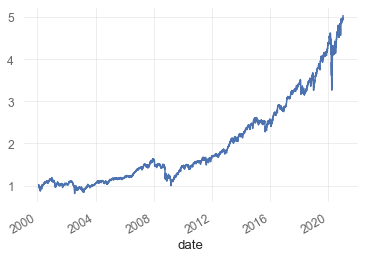

In [121]:
bnch_ret.plot()

In [125]:
df_ret = df_stocks_betas_options.pivot_table(index='date',columns='permno',values='ret')

# Optimization

In [122]:
from scipy.stats import norm

In [138]:
# Strahi
def configure_inputs_for_optimisation(df, ret, expret, d, limit, lookback,
                                      regressors):   # Add regressor

    cov = ret.cov().values
    mu  = expret.iloc[-1].values
    
    if np.sum(mu > 0) == 0:   # TODO: Why?
        mu -= mu.mean()
    
 # ----- Bounds on Weights Based on Benchmark on day d  ---- #
    bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
    for en,i in enumerate(ret.columns, start=0): # 
        
        lower_bound  = 0.9*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        higher_bound = 1.1*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        bounds[en].extend((lower_bound,higher_bound))
              
 # ----- Constraints on Factor Exposure: ---- #
    cons = []
    fact = pd.DataFrame(columns=regressors+['permno'] )
    fact.permno = ret.columns.tolist()
    fact.set_index('permno', inplace=True)
    fact = fact.fillna(0.0)
    
    for stock in fact.index:
        for fct in fact.columns:
            flt = np.logical_and(df['date'] == d, df['permno'] == stock)
            if flt.any():
                fact.loc[stock, fct] = train.loc[flt, fct].values[0]
    
    B = fact.T  # (N of factors * N of permno)
    
    cons.append({'type': 'ineq', 'fun' : lambda wvec: limit - B@wvec})  # B @ wvec --> (N of factors * 1)
    cons.append({'type': 'ineq', 'fun' : lambda wvec: B@wvec + limit}) 
 
 # ----- Constraints on Weight Sum (long portfolio): ---- #

    cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1})

#  # ----- Constraints on Drawdown: ---- #
#     if (pd.Timestamp(d)- BDay(lookback)) in ret.index :
#                                  means, cov_var, bench_dd = Benchmark_Drawdown_Rolling(df,ret,d,lookback=21)
#                                  qs_dd = np.array(norm.pdf(0.01,loc = means@wvec, scale = np.sqrt(np.array(wvec.T)@cov_var@np.array(wvec))))
#                                  cons.append({'type': 'ineq', 'fun' : lambda wvec: (qs_dd - bench_dd +0.01)})                                                                  
                                        
                                 
    return cov, mu, cons, bounds

In [141]:
[i+'_ws' for i in betas]

['mktrf_beta_eom_ws',
 'smb_beta_eom_ws',
 'hml_beta_eom_ws',
 'mom_beta_eom_ws',
 'glb2_D30_ws',
 'glb3_D30_ws',
 'glb2_D91_ws',
 'glb3_D91_ws',
 'glb2_D182_ws',
 'glb3_D182_ws',
 'glb2_D273_ws',
 'glb3_D273_ws',
 'glb2_D365_ws',
 'glb3_D365_ws',
 'mfis30_ws',
 'mfis91_ws',
 'mfis182_ws',
 'mfis273_ws',
 'mfis365_ws']

In [146]:
df_stocks_betas_options

,date,permno,cusip,ret,prc,weightage_pct,secid,rf,excess_return,const_eom,...,glb2_D365,glb3_D365,mfis30,mfis91,mfis182,mfis273,mfis365,fret1d,constant,bnch_ret_contrib
0,2000-01-31,61241.0,00790310,0.021277,36.000000,0.004653,101121.0,0.00021,0.021067,0.001023,...,0.093748,0.093602,-0.200818,0.034994,0.103173,0.163144,0.188699,0.015625,1,0.000099
1,2000-01-31,56274.0,20588710,0.036254,21.437500,0.009096,103313.0,0.00021,0.036044,-0.000982,...,0.093748,0.093602,0.411800,0.040337,-0.250504,0.163144,0.188699,-0.017493,1,0.000330
2,2000-01-31,53613.0,59511210,0.036458,62.187500,0.013615,107544.0,0.00021,0.036248,-0.000732,...,0.059453,0.059433,-0.196034,-0.141617,-0.039893,0.030999,0.095062,0.021106,1,0.000496
3,2000-01-31,53065.0,46069010,-0.021277,46.000000,0.011782,106329.0,0.00021,-0.021487,-0.000090,...,0.059453,0.059433,-0.770791,-0.280034,-0.280038,0.030999,0.095062,0.047554,1,-0.000251
4,2000-01-31,47466.0,65011110,-0.013495,45.687500,0.007049,108117.0,0.00021,-0.013705,0.001423,...,0.059453,0.059433,-0.682779,-0.008300,-0.007227,0.030999,0.095062,0.015048,1,-0.000095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263292,2020-12-31,24205.0,65339F10,0.016335,77.150002,0.046879,104560.0,0.00000,0.016335,0.001267,...,0.106649,0.108175,-1.315134,-1.266830,-1.193949,-1.092384,-1.035077,NaN,1,0.000766
263293,2020-12-31,25320.0,13442910,0.006872,48.349998,0.004576,102660.0,0.00000,0.006872,0.000428,...,0.062504,0.063150,-0.658668,-0.647218,-0.669322,-0.626716,-0.731296,NaN,1,0.000031
263294,2020-12-31,26825.0,48783610,0.011377,62.230000,0.006667,106638.0,0.00000,0.011377,0.000154,...,0.062857,0.063785,-0.898440,-0.870173,-0.854332,-0.809697,-0.710303,NaN,1,0.000076
263295,2020-12-31,18729.0,19416210,0.009206,85.510002,0.022894,103157.0,0.00000,0.009206,0.000622,...,0.080567,0.081668,-0.864212,-1.308622,-1.148902,-1.092384,-1.035077,NaN,1,0.000211


In [148]:
df_test.loc[df_test['date']=='2013-01-03', [i+'_ws' for i in betas]]

,mktrf_beta_eom_ws,smb_beta_eom_ws,hml_beta_eom_ws,mom_beta_eom_ws,glb2_D30_ws,glb3_D30_ws,glb2_D91_ws,glb3_D91_ws,glb2_D182_ws,glb3_D182_ws,glb2_D273_ws,glb3_D273_ws,glb2_D365_ws,glb3_D365_ws,mfis30_ws,mfis91_ws,mfis182_ws,mfis273_ws,mfis365_ws
162624,1.456651,0.723902,0.046787,-0.147780,0.041527,0.041526,0.040293,0.040288,0.041681,0.041637,0.041418,0.041369,0.042676,0.042627,-0.778885,-0.707478,-0.666566,-0.413956,-0.326256
162625,0.700075,-0.381209,0.113402,0.288724,0.024818,0.024834,0.024999,0.025014,0.025716,0.025730,0.027121,0.027134,0.028345,0.028359,-0.679460,-0.798243,-0.843725,-0.838913,-0.959838
162626,0.396636,-0.166808,0.268098,0.436051,0.014603,0.014616,0.014907,0.014780,0.014907,0.014920,0.015739,0.015752,0.016550,0.016563,-0.786227,-0.895099,-0.989259,-0.961215,-1.104825
162627,1.123021,0.615656,0.953917,0.296344,0.052781,0.052768,0.037405,0.037411,0.034620,0.034627,0.015739,0.015752,0.016550,0.016563,-1.286847,-0.498232,-0.989259,-0.961215,-1.104825
162628,0.452435,-0.165479,0.116238,0.174469,0.020413,0.020427,0.019863,0.019875,0.021272,0.021285,0.022874,0.022885,0.023907,0.023920,-0.689070,-1.033324,-1.090508,-1.089432,-1.253818
162629,1.173031,-0.184982,0.242827,-0.576333,0.036956,0.036957,0.034943,0.034941,0.037355,0.037353,0.038125,0.038118,0.040014,0.040009,-0.546872,-0.625612,-0.645143,-0.660520,-0.657344
162630,0.505480,-0.157535,0.035669,0.271765,0.018892,0.018907,0.018639,0.018653,0.018490,0.018504,0.038125,0.038118,0.040014,0.040009,-0.979583,-0.728801,-0.645143,-0.660520,-0.657344
162631,0.424380,-0.076705,0.053440,0.201046,0.016047,0.016060,0.018620,0.018632,0.018533,0.018546,0.019397,0.019409,0.022224,0.022238,-1.216788,-1.115342,-1.089282,-1.089432,-1.253818
162632,0.546397,-0.240845,0.141981,0.428990,0.020275,0.020290,0.019537,0.019551,0.020005,0.020018,0.022096,0.022109,0.023428,0.023442,-0.985556,-0.948588,-0.992872,-1.089432,-1.253818
162633,0.569072,-0.101706,0.189405,0.416386,0.018889,0.018903,0.017041,0.017053,0.018128,0.018141,0.019055,0.019067,0.019683,0.019695,-1.384603,-1.079610,-1.040027,-1.089432,-1.253818


In [164]:
ret_pred = lassolr.predict(df_test.loc[df_test['date']=='2013-01-03', [i+'_ws' for i in betas]])

In [165]:
ret_pred_ = pd.DataFrame(data=ret_pred,
                         index=df_test.loc[df_test['date']=='2013-01-03', 'permno'].values,
                         columns=['exp_ret'])
ret_pred_

,exp_ret
10874.0,0.000483
11308.0,0.000483
11404.0,0.000483
11786.0,0.000483
13856.0,0.000483
16432.0,0.000483
16600.0,0.000483
17144.0,0.000483
17750.0,0.000483
18163.0,0.000483


In [167]:
configure_inputs_for_optimisation(df=df_stocks_betas_options, 
                                  ret=df_ret, expret=ret_pred_, d='2013-01-04', 
                                  limit=0.05, lookback=30,
                                  regressors=[i+'_ws' for i in betas])

KeyError: 'mktrf_beta_eom_ws'

In [139]:
df_ret

permno,10874.0,11308.0,11404.0,11786.0,13856.0,16432.0,16600.0,17144.0,17750.0,18163.0,...,75341.0,76644.0,77649.0,80539.0,82598.0,83601.0,84519.0,85663.0,86102.0,88664.0
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.006645,0.008782,0.003839,0.023523,0.026316,0.013333,0.125828,0.030992,-0.015842,0.007477,...,0.006349,-0.026895,0.030675,-0.059356,0.011972,0.013158,-0.007561,-0.003257,-0.036585,-0.019272
2000-02-01,0.000000,0.011970,0.005736,0.058296,-0.003663,0.010526,-0.045588,-0.030060,-0.009054,-0.015461,...,0.009464,0.000000,0.059524,-0.007487,0.074097,0.030303,0.055238,0.032680,0.009494,-0.039301
2000-02-02,-0.006601,-0.030108,-0.011407,-0.021186,-0.029412,-0.031250,0.003082,-0.004132,0.001015,-0.008794,...,0.003125,-0.002513,0.056180,0.141164,0.049275,0.009454,0.070397,-0.022152,0.050157,0.000000
2000-02-03,-0.039867,-0.019956,0.009615,0.004329,0.001894,-0.021505,0.016897,0.016598,0.013185,-0.008238,...,0.009346,-0.015113,-0.042553,-0.006610,0.013260,-0.001041,0.017707,-0.003236,0.055737,0.004545
2000-02-04,0.017301,0.018100,-0.017143,0.011853,-0.009452,-0.021978,0.003021,-0.008163,-0.014014,-0.031310,...,-0.006173,-0.005115,0.011111,0.082700,0.116140,-0.050000,0.001657,-0.016234,-0.016997,0.063348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-0.005613,0.006782,0.005280,-0.004053,0.004501,-0.011450,0.003346,0.002373,0.002921,0.010122,...,0.014455,-0.004742,0.011023,-0.003241,-0.005592,0.019663,0.014286,0.007318,0.003517,0.011287
2020-12-28,-0.013867,0.013473,0.011641,0.005373,0.012753,-0.004826,0.012337,0.003721,0.000448,0.006971,...,0.010687,-0.028589,-0.002524,0.011924,0.001520,-0.004329,0.004131,-0.024203,-0.002804,0.012810
2020-12-29,-0.028621,-0.000554,-0.007017,-0.005317,0.003471,0.000485,-0.002372,-0.003370,0.001344,-0.001875,...,-0.007049,0.007971,-0.000700,-0.022496,-0.012898,-0.011660,-0.021694,-0.002467,-0.010896,-0.002692


In [136]:
dates = df_stocks_betas_options.loc[df_stocks_betas_options['date']>'2012-12-31','date'].unique()

In [ ]:
for d in tqdm(dates):
    

In [127]:
np.logical_and(df_stocks_betas_options['date'] == '2020-12-31', df_stocks_betas_options['permno'] == 24205)

0         False
1         False
2         False
3         False
4         False
          ...  
263292     True
263293    False
263294    False
263295    False
263296    False
Length: 263297, dtype: bool

In [133]:
df_stocks_betas_options.loc[np.logical_and(df_stocks_betas_options['date'] == '2020-12-31', df_stocks_betas_options['permno'] == 24205), 
          'glb3_D273'].values[0]

0.1059865342258587

In [ ]:
pd.datetime(2012, 12, 31)